# Geometry Optimization

We present here a complete example on how to use QMCTorch to optimize the geometry of a H2 molecule.
As previously the first task is to import all the modules needed

In [1]:
from torch import optim
from torch.optim import Adam
from qmctorch.wavefunction import SlaterJastrow
from qmctorch.solver import Solver
from qmctorch.sampler import Metropolis
from qmctorch.scf import Molecule
from qmctorch.utils.plot_data import plot_energy
from qmctorch.utils import set_torch_double_precision

set_torch_double_precision()

INFO:QMCTorch|  ____    __  ______________             _
INFO:QMCTorch| / __ \  /  |/  / ___/_  __/__  ________/ /  
INFO:QMCTorch|/ /_/ / / /|_/ / /__  / / / _ \/ __/ __/ _ \ 
INFO:QMCTorch|\___\_\/_/  /_/\___/ /_/  \___/_/  \__/_//_/ 


We then define the molecule. We create a H2 molecule with a short atomic distance that we will then try to relax


In [2]:
mol = Molecule(
    atom="H 0. 0. -0.5; H 0. 0. 0.5",
    unit="bohr",
    calculator="pyscf",
    basis="sto-3g",
    redo_scf=True,
)

INFO:QMCTorch|
INFO:QMCTorch| SCF Calculation
INFO:QMCTorch|  Running scf  calculation
converged SCF energy = -1.06599946214331
INFO:QMCTorch|  Molecule name       : H2
INFO:QMCTorch|  Number of electrons : 2
INFO:QMCTorch|  SCF calculator      : pyscf
INFO:QMCTorch|  Basis set           : sto-3g
INFO:QMCTorch|  SCF                 : HF
INFO:QMCTorch|  Number of AOs       : 2
INFO:QMCTorch|  Number of MOs       : 2
INFO:QMCTorch|  SCF Energy          : -1.066 Hartree


As for the wave function optimization example we need to define a wave function, a sampler an optimizer and a solver.

In [3]:
# wave function with only the ground state determinant
wf = SlaterJastrow(mol, configs="single_double(2,2)").gto2sto()

# sampler
sampler = Metropolis(
    nwalkers=1000,
    nstep=200,
    step_size=0.5,
    nelec=wf.nelec,
    ndim=wf.ndim,
    ntherm=-1,
    ndecor=100,
    init=mol.domain("normal"),
    move={"type": "all-elec", "proba": "normal"},
)
# optimizer
opt = Adam(wf.parameters(), lr=0.005)

# scheduler
scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.75)

INFO:QMCTorch|
INFO:QMCTorch| Wave Function
INFO:QMCTorch|  Jastrow factor      : True
INFO:QMCTorch|  Jastrow kernel      : ee -> PadeJastrowKernel
INFO:QMCTorch|  Highest MO included : 2
INFO:QMCTorch|  Configurations      : single_double(2,2)
INFO:QMCTorch|  Number of confs     : 4
INFO:QMCTorch|  Kinetic energy      : jacobi
INFO:QMCTorch|  Number var  param   : 21
INFO:QMCTorch|  Cuda support        : False
INFO:QMCTorch|  Fit GTOs to STOs  : 
INFO:QMCTorch|
INFO:QMCTorch| Wave Function
INFO:QMCTorch|  Jastrow factor      : True
INFO:QMCTorch|  Jastrow kernel      : ee -> PadeJastrowKernel
INFO:QMCTorch|  Highest MO included : 2
INFO:QMCTorch|  Configurations      : single_double(2,2)
INFO:QMCTorch|  Number of confs     : 4
INFO:QMCTorch|  Kinetic energy      : jacobi
INFO:QMCTorch|  Number var  param   : 17
INFO:QMCTorch|  Cuda support        : False
INFO:QMCTorch|
INFO:QMCTorch| Monte-Carlo Sampler
INFO:QMCTorch|  Number of walkers   : 1000
INFO:QMCTorch|  Number of steps     : 

In [4]:
solver = Solver(wf=wf, sampler=sampler, optimizer=opt, scheduler=None)
solver.configure(
    loss="energy", grad="auto", track=["local_energy", "geometry"], freeze=["ao"]
)

INFO:QMCTorch|
INFO:QMCTorch| QMC Solver 
INFO:QMCTorch|  WaveFunction        : SlaterJastrow
INFO:QMCTorch|  Sampler             : Metropolis
INFO:QMCTorch|  Optimizer           : Adam


Note that we must set `grad='auto'` to perform a geometry optimization. To optimize the geometry of the molecule we must use the `set_params_requires_grad` method of the solver. We here set all the wave function parameters and all the atomic positions as variational parameters, leading to a simultaneous optimization of the wave function and of the atomic coordinates. We can then run the optimization here using 50 epochs

In [5]:
solver.set_params_requires_grad(wf_params=False, geo_params=True)
obs = solver.run(50)

INFO:QMCTorch|
INFO:QMCTorch|  Optimization
INFO:QMCTorch|  Task                :
INFO:QMCTorch|  Number Parameters   : 6
INFO:QMCTorch|  Number of epoch     : 50
INFO:QMCTorch|  Batch size          : 1000
INFO:QMCTorch|  Loss function       : energy
INFO:QMCTorch|  Clip Loss           : False
INFO:QMCTorch|  Gradients           : auto
INFO:QMCTorch|  Resampling mode     : update
INFO:QMCTorch|  Resampling every    : 1
INFO:QMCTorch|  Resampling steps    : 25
INFO:QMCTorch|  Output file         : H2_pyscf_sto-3g_QMCTorch.hdf5
INFO:QMCTorch|  Checkpoint every    : None
INFO:QMCTorch|
INFO:QMCTorch|
INFO:QMCTorch|  epoch 0 | 1000 sampling points
INFO:QMCTorch|  energy   : -1.051299 +/- 0.011930
INFO:QMCTorch|  variance : 0.377259
INFO:QMCTorch|  epoch done in 0.08 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 1 | 1000 sampling points
INFO:QMCTorch|  energy   : -1.039677 +/- 0.011319
INFO:QMCTorch|  variance : 0.357927
INFO:QMCTorch|  epoch done in 0.11 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epo

In [6]:
solver.save_traj("h2_traj.xyz", obs)

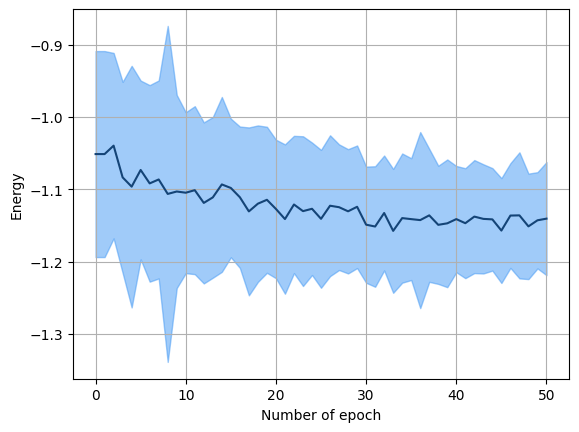

In [7]:
plot_energy(obs.local_energy)